### Working with already created model and coefficients
Cuando trabajamos con un modelo y coeficientes ya generados, es mas sencillo

In [280]:
import pyEXP
import EXPtools
import h5py
import numpy as np

In [279]:
"""
Version information
-----------------------
Version:          EXP 7.7.28
Repository URL:   https://github.com/EXP-code/EXP
GIT branch:       pyEXPfix
GIT commit:       50566b3ff70eb6debf3bf62d814ce9db7694a8c9
Compile time:     2024-03-28 13:07:55 UTC
"""

'\nVersion information\n-----------------------\nVersion:          EXP 7.7.28\nRepository URL:   https://github.com/EXP-code/EXP\nGIT branch:       pyEXPfix\nGIT commit:       50566b3ff70eb6debf3bf62d814ce9db7694a8c9\nCompile time:     2024-03-28 13:07:55 UTC\n'

In [3]:
model = 'Hernquist'
Hern_config = EXPtools.basis_builder.basis_utils.make_config('sphereSL',lmax=6,nmax=20,
                                             modelname=f'{model}_model.txt',cachename=f'{model}_halo.cache',
                                             numr=200, rmin=2.5, rmax=300, scale=1)
Hern_basis = pyEXP.basis.Basis.factory(Hern_config)
Hern_coefs = pyEXP.coefs.Coefs.factory('Hernquist_halo.h5')

---- SLGridSph::ReadH5Cache: parameter numr: wanted 200 found 201
---- SLGridSph::WriteH5Cache cache file <Hernquist_halo.cache> exists
---- SLGridSph::WriteH5Cache: existing file backed up to <Hernquist_halo.cache.bak>
---- SLGridSph::WriteH5Cache: wrote <Hernquist_halo.cache>
SphericalSL::orthoTest: worst=0.0231541


In [4]:
model = 'NFW'
NFW_config = EXPtools.basis_builder.basis_utils.make_config('sphereSL',lmax=6,nmax=20,
                                             modelname=f'{model}_model.txt',cachename=f'{model}_halo.cache',
                                             numr=500, rmin=2.5, rmax=300, scale=1)
NFW_basis = pyEXP.basis.Basis.factory(NFW_config)
NFW_coefs = pyEXP.coefs.Coefs.factory('NFW_halo.h5')

---- SLGridSph::ReadH5Cache: parameter numr: wanted 500 found 501
---- SLGridSph::WriteH5Cache cache file <NFW_halo.cache> exists
---- SLGridSph::WriteH5Cache: existing file backed up to <NFW_halo.cache.bak>
---- SLGridSph::WriteH5Cache: wrote <NFW_halo.cache>
SphericalSL::orthoTest: worst=0.0429877


Text(0.5, 0.98, 'Orthogonal tests')

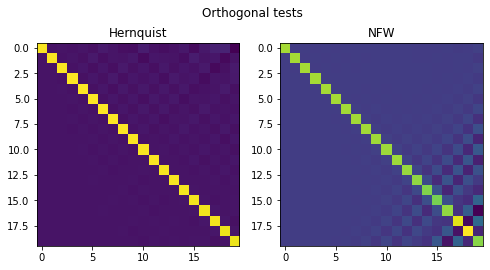

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(Hern_basis.orthoCheck()[0])
ax[1].imshow(NFW_basis.orthoCheck()[0])
ax[0].set_title('Hernquist')
ax[1].set_title('NFW')

fig.suptitle('Orthogonal tests')

#### Extraccion de perfiles de las bases

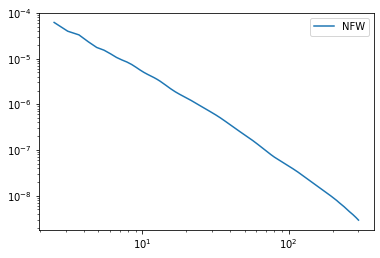

In [325]:
field = 'dens'

rad_NFW, field_dens_NFW = EXPtools.visuals.visualize.spherical_avg_prop(NFW_basis,NFW_coefs, rmin=2.5, rmax=300, nbins=500, log_space=False, time=0, property=field, include_monopole=False)
#rad_Hern, field_dens_Hern = EXPtools.visuals.visualize.spherical_avg_prop(Hern_basis,Hern_coefs, rmin=2.5, rmax=300, nbins=200, log_space=False, time=0, property=field, include_monopole=False)
plt.plot(rad_NFW, field_dens_NFW, label='NFW')
#plt.plot(rad_Hern, field_dens_Hern, label='Hernquist')
plt.xscale('log')
plt.yscale('log')
plt.legend()

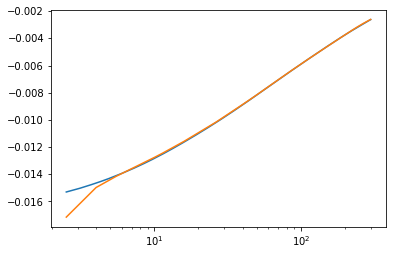

In [23]:
field = 'pot'

rad_NFW, field_pot_NFW = EXPtools.visuals.visualize.spherical_avg_prop(NFW_basis,NFW_coefs, rmin=2.5, rmax=300, nbins=500, log_space=False, time=0, property=field, include_monopole=False)
rad_Hern, field_pot_Hern = EXPtools.visuals.visualize.spherical_avg_prop(Hern_basis,Hern_coefs, rmin=2.5, rmax=300, nbins=200, log_space=False, time=0, property=field, include_monopole=False)
plt.plot(rad_NFW, field_pot_NFW)
plt.plot(rad_Hern, field_pot_Hern)
plt.xscale('log')

### Comparing with empirical values

In [296]:
id = 372754
# Obtained from the header file
HubbleParam  =  0.6774
Omega0  =  0.3089
OmegaLambda  =  0.6911
Redshift  =  2.220446049250313e-16
Time  =  0.9999999999999998 # Is also defined as the scale factor a, since z~0, a~1
with h5py.File(f"subhalo_{id}.hdf5", "r") as file:
    print(file['99/dm'].keys())
    pos = np.array(file['99/dm/Coordinates_centered'])
    radius = np.array(file['99/dm/Distance_to_center'])
    mass = np.full(pos.shape[0],3.1e5/HubbleParam)

<KeysViewHDF5 ['Coordinates', 'Coordinates_centered', 'Distance_to_center', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'Velocities', 'count']>


In [297]:
bins = 500
rmin, rmax = rad_NFW[0],rad_NFW[-1]
rbins = np.linspace(rmin,rmax,bins)

In [298]:
R = np.linalg.norm(pos,axis=1)
max(R)
filtr = np.where((R < rmax) & (R > rmin))[0]

In [332]:
emp_dens = EXPtools.basis_builder.makemodel.empirical_density_profile(rbins,pos[filtr],mass[filtr]/sum(mass[filtr]))

(None, None, Text(0, 0.5, 'mass density'), Text(0.5, 0, 'Radius(kpc)'))

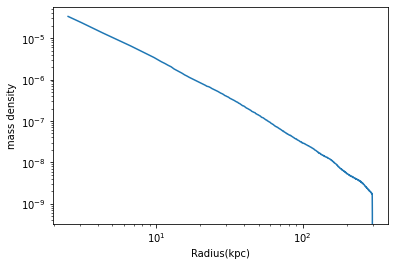

In [333]:
plt.plot(rbins[:-1],emp_dens)
plt.xscale('log'),plt.yscale('log'),plt.ylabel('mass density'),plt.xlabel('Radius(kpc)')

#### Modelos base en comparacion al empirico

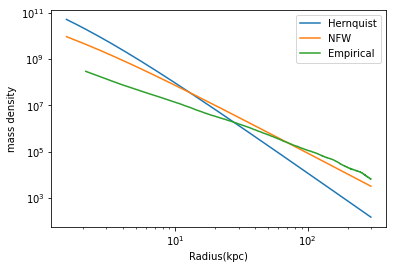

In [71]:
# Comparando con orden cero
emp_dens_nonorm = EXPtools.basis_builder.makemodel.empirical_density_profile(rbins,pos,mass)

fig, ax = plt.subplots(1,1,figsize=(6,4))

read_model = np.loadtxt('Hernquist_model.txt', skiprows=3)
ax.plot(read_model[:,0],read_model[:,1], label='Hernquist')
ax.set_xscale('log')
ax.set_yscale('log')

read_model = np.loadtxt('NFW_model.txt', skiprows=3)
ax.plot(read_model[:,0],read_model[:,1], label='NFW')

ax.plot(rbins[1:],emp_dens_nonorm, label='Empirical')
ax.set_xscale('log'),ax.set_yscale('log'),ax.set_ylabel('mass density'),ax.set_xlabel('Radius(kpc)')

ax.legend()

#### Ahora utilizando los perfiles de las bases
comparando perfil empirico con el obtenido de la expansion completa

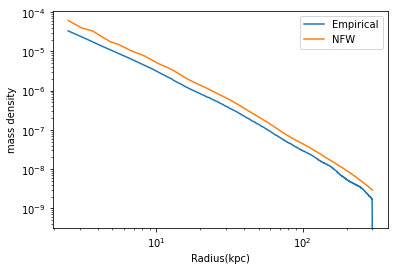

In [334]:
rad_NFW, field_dens_NFW = EXPtools.visuals.visualize.spherical_avg_prop(NFW_basis,NFW_coefs, rmin=2.5, rmax=300, nbins=500, log_space=False, time=0, property='dens', include_monopole=False)
#rad_Hern, field_dens_Hern = EXPtools.visuals.visualize.spherical_avg_prop(Hern_basis,Hern_coefs, rmin=2.5, rmax=300, nbins=200, log_space=False, time=0, property='dens', include_monopole=False)

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(rbins[:-1],emp_dens, label='Empirical')
ax.plot(rad_NFW[:], field_dens_NFW[:], label='NFW')
#ax.plot(rad_Hern, field_dens_Hern, label='Hernquist')

ax.set_xscale('log'),ax.set_yscale('log'),ax.set_ylabel('mass density'),ax.set_xlabel('Radius(kpc)')
ax.legend()

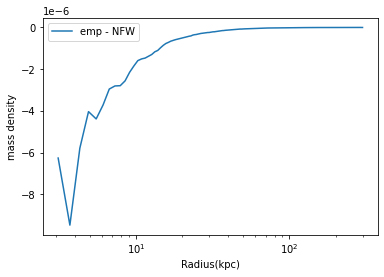

In [335]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(rbins[1:],emp_dens - field_dens_NFW[1:], label='emp - NFW')

ax.set_xscale('log'),ax.set_ylabel('mass density'),ax.set_xlabel('Radius(kpc)')
ax.legend()

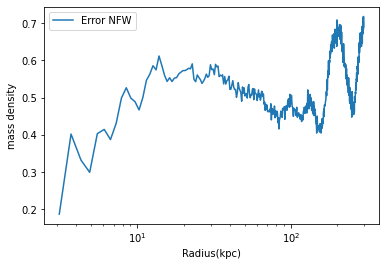

In [338]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(rbins[1:-3],abs(emp_dens[:-3] - field_dens_NFW[1:-3])/emp_dens[:-3], label='Error NFW')

ax.set_xscale('log'),ax.set_ylabel('mass density'),ax.set_xlabel('Radius(kpc)')
ax.legend()

#### Comparando slices de Hernquist y NFW

In [317]:
def empirical_slice(pos, mass,
                    projection='XY', proj_plane=0, Lz= 1e-1,
                    npoints=300, grid_limits=(-300,300),
                    prop='dens'):
    if projection not in ['XY','XZ','YZ']:
        raise valueError('Invalid Projection, must be XY, XZ , or YZ')
    if projection == 'XY':
        in_slice = np.where(abs(pos[:,2]) < proj_plane+Lz)[0]
    elif projection == 'XZ':
        in_slice = np.where(abs(pos[:,1]) < proj_plane+Lz)[0]
    elif projection == 'YZ':
        in_slice = np.where(abs(pos[:,0]) < proj_plane+Lz)[0]
    pos_slice,mass_slice = pos[in_slice,:],mass[in_slice]
    print(pos_slice.shape)
    rho, xbins, ybins = np.histogram2d(pos_slice[:,0],pos_slice[:,1],bins=npoints, weights=mass_slice**-1,
                                       range=[[grid_limits[0],grid_limits[1]],[grid_limits[0],grid_limits[1]]])
    rho = rho/Lz
    return (xbins[0:-1], ybins[0:-1], rho)

In [318]:
x = np.linspace(-300,300,300)
xgrid = np.meshgrid(x,x)

In [319]:
xgrid[0]

array([[-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
         297.99331104,  300.        ],
       [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
         297.99331104,  300.        ],
       [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
         297.99331104,  300.        ],
       ...,
       [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
         297.99331104,  300.        ],
       [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
         297.99331104,  300.        ],
       [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
         297.99331104,  300.        ]])

(763745, 3)


/tmp/ipykernel_5886/2673884914.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(xbins,ybins,np.log10(rho))
/tmp/ipykernel_5886/2673884914.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.contour(xbins,ybins,np.log10(rho), zorder=100, c='k')
/tmp/ipykernel_5886/2673884914.py:4: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contour(xbins,ybins,np.log10(rho), zorder=100, c='k')


((300, 300), 0.007439163096775621)

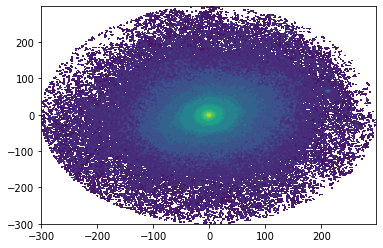

In [341]:
filtr = np.where(R < 300)
xbins, ybins, rho = empirical_slice(pos[filtr],mass[filtr], Lz=5)
plt.contourf(xbins,ybins,np.log10(rho))
plt.contour(xbins,ybins,np.log10(rho), zorder=100, c='k')
rho.shape,rho[150,150]

In [129]:
NFWdens0, NFWdens, NFWxgrid = EXPtools.visuals.visualize.slice_fields(NFW_basis,NFW_coefs)

In [130]:
Herndens0, Herndens, Hernxgrid = EXPtools.visuals.visualize.slice_fields(Hern_basis,Hern_coefs)

In [323]:
EXPtools.visuals.visualize.slice_fields?

Signature:
EXPtools.visuals.visualize.slice_fields(
    basis,
    coefficients,
    time=0,
    projection='XY',
    proj_plane=0,
    npoints=300,
    grid_limits=(-300, 300),
    prop='dens',
    monopole_only=False,
)
Docstring:
Plots a slice projection of the fields of a simulation.

Args:
basis (obj): object containing the basis functions for the simulation
coefficients (obj): object containing the coefficients for the simulation
time (float): the time at which to plot the fields
projection (str): the slice projection to plot. Can be 'XY', 'XZ', or 'YZ'.
proj_plane (float, optional): the value of the coordinate that is held constant in the slice projection
npoints (int, optional): the number of grid points in each dimension
grid_limits (tuple, optional): the limits of the grid in the x and y dimensions, in the form (x_min, x_max)
prop (str, optional): the property to return. Can be 'dens' (density), 'pot' (potential), or 'force' (force).
monopole_only (bool, optional): whether to

In [222]:
NFWdens.shape,Herndens.shape,rho.shape,NFWdens[150,150],Herndens[150,150],rho[150,150],NFWxgrid[:],Hernxgrid[:],xbins,ybins

((300, 300),
 (300, 300),
 (300, 300),
 2.8367223813184113e-05,
 0.00023209492856539392,
 0.01840561354838938,
 [array([[-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
           297.99331104,  300.        ],
         [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
           297.99331104,  300.        ],
         [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
           297.99331104,  300.        ],
         ...,
         [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
           297.99331104,  300.        ],
         [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
           297.99331104,  300.        ],
         [-300.        , -297.99331104, -295.98662207, ...,  295.98662207,
           297.99331104,  300.        ]]),
  array([[-300.        , -300.        , -300.        , ..., -300.        ,
          -300.        , -300.        ],
         [-297.99331104, -297.99331104, -297.99331104, ..., -

/tmp/ipykernel_5886/3603021071.py:3: RuntimeWarning: invalid value encountered in log10
  NFWcont = ax[0,0].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
/tmp/ipykernel_5886/3603021071.py:5: RuntimeWarning: invalid value encountered in log10
  ax[0,0].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens), zorder=100, colors='k')
/tmp/ipykernel_5886/3603021071.py:9: RuntimeWarning: invalid value encountered in log10
  Herncont = ax[0,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens))
/tmp/ipykernel_5886/3603021071.py:11: RuntimeWarning: invalid value encountered in log10
  ax[0,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens), zorder=100, colors='k')
/tmp/ipykernel_5886/3603021071.py:22: RuntimeWarning: divide by zero encountered in log10
  empcont = ax[1,0].contourf(xbins,ybins,np.log10(rho))
/tmp/ipykernel_5886/3603021071.py:28: RuntimeWarning: invalid value encountered in log10
  NFWcont = ax[1,1].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
/tmp/ipykernel_5886

(-300.0, 298.0, -300.0, 298.0)

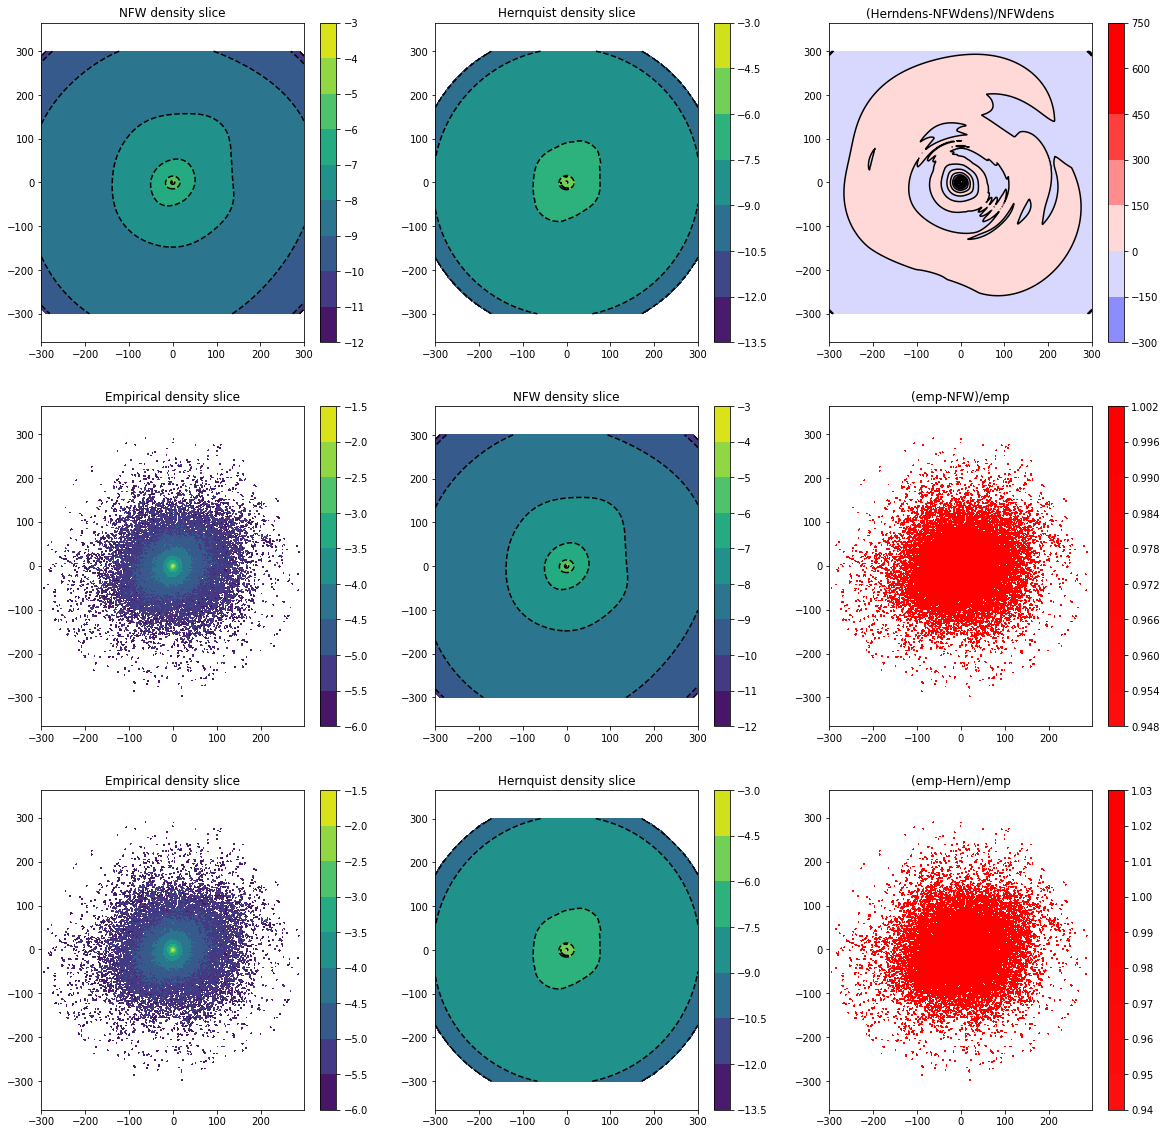

In [321]:
fig, ax = plt.subplots(3,3,figsize=(20,20))

NFWcont = ax[0,0].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
plt.colorbar(NFWcont)
ax[0,0].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens), zorder=100, colors='k')
ax[0,0].set_title('NFW density slice')
ax[0,0].axis('equal')

Herncont = ax[0,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens))
plt.colorbar(Herncont)
ax[0,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens), zorder=100, colors='k')
ax[0,1].set_title('Hernquist density slice')
ax[0,1].axis('equal')

diff = (Herndens-NFWdens)/NFWdens
diffcont = ax[0,2].contourf(Hernxgrid[0],Hernxgrid[1],diff,cmap='bwr',vmin=-500,vmax=500)
cbar = plt.colorbar(diffcont)
ax[0,2].contour(Hernxgrid[0],Hernxgrid[1],(NFWdens-Herndens)/NFWdens, zorder=100, colors='k')
ax[0,2].set_title('(Herndens-NFWdens)/NFWdens')
ax[0,2].axis('equal')

empcont = ax[1,0].contourf(xbins,ybins,np.log10(rho))
plt.colorbar(empcont)
#ax[1,0].contour(xbins,ybins,np.log10(rho), zorder=100, colors='k')
ax[1,0].set_title('Empirical density slice')
ax[1,0].axis('equal')

NFWcont = ax[1,1].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
plt.colorbar(NFWcont)
ax[1,1].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens), zorder=100, colors='k')
ax[1,1].set_title('NFW density slice')
ax[1,1].axis('equal')

diff = (rho-NFWdens)/rho
diffcont = ax[1,2].contourf(xbins,ybins,diff,cmap='bwr',vmin=-1,vmax=1)
cbar = plt.colorbar(diffcont)
ax[1,2].set_title('(emp-NFW)/emp')
ax[1,2].axis('equal')

empcont = ax[2,0].contourf(xbins,ybins,np.log10(rho))
plt.colorbar(empcont)
#ax[1,0].contour(xbins,ybins,np.log10(rho), zorder=100, colors='k')
ax[2,0].set_title('Empirical density slice')
ax[2,0].axis('equal')

Herncont = ax[2,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens))
plt.colorbar(Herncont)
ax[2,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens), zorder=100, colors='k')
ax[2,1].set_title('Hernquist density slice')
ax[2,1].axis('equal')

diff = (rho-Herndens)/rho
diffcont = ax[2,2].contourf(xbins,ybins,diff,cmap='bwr',vmin=-1,vmax=1)
cbar = plt.colorbar(diffcont)
ax[2,2].set_title('(emp-Hern)/emp')
ax[2,2].axis('equal')

/tmp/ipykernel_5886/2332152054.py:3: RuntimeWarning: invalid value encountered in log10
  NFWcont = ax[0,0].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
/tmp/ipykernel_5886/2332152054.py:5: RuntimeWarning: invalid value encountered in log10
  ax[0,0].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens), zorder=100, colors='k')
/tmp/ipykernel_5886/2332152054.py:9: RuntimeWarning: invalid value encountered in log10
  Herncont = ax[0,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens))
/tmp/ipykernel_5886/2332152054.py:11: RuntimeWarning: invalid value encountered in log10
  ax[0,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens), zorder=100, colors='k')
/tmp/ipykernel_5886/2332152054.py:22: RuntimeWarning: divide by zero encountered in log10
  empcont = ax[1,0].contourf(xbins,ybins,np.log10(rho/100))
/tmp/ipykernel_5886/2332152054.py:28: RuntimeWarning: invalid value encountered in log10
  NFWcont = ax[1,1].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
/tmp/ipykernel_

(-300.0, 298.0, -300.0, 298.0)

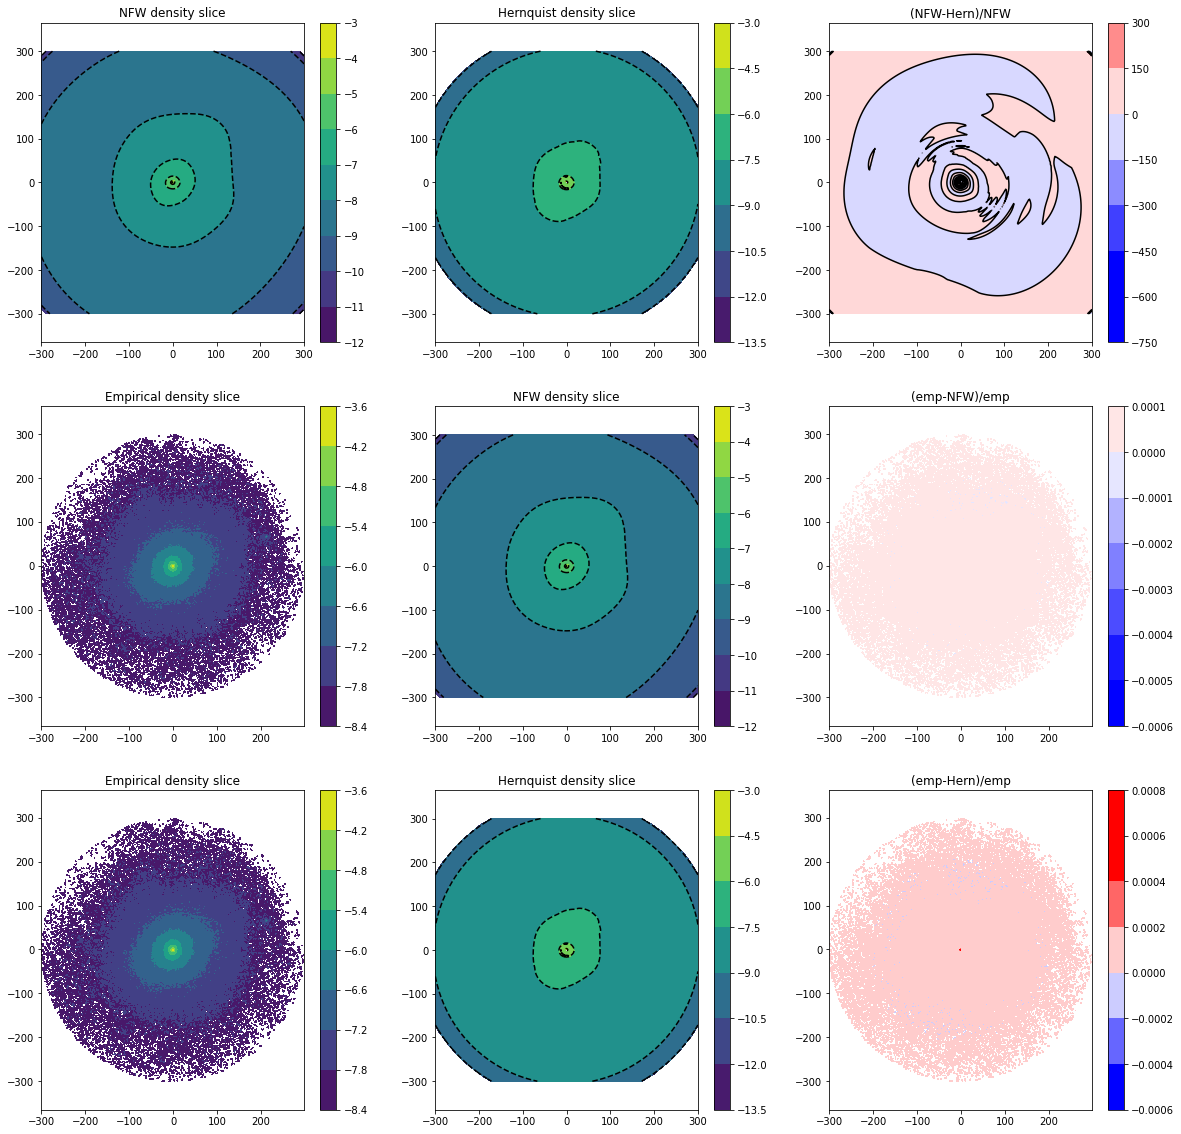

In [342]:
fig, ax = plt.subplots(3,3,figsize=(20,20))

NFWcont = ax[0,0].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
plt.colorbar(NFWcont)
ax[0,0].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens), zorder=100, colors='k')
ax[0,0].set_title('NFW density slice')
ax[0,0].axis('equal')

Herncont = ax[0,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens))
plt.colorbar(Herncont)
ax[0,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens), zorder=100, colors='k')
ax[0,1].set_title('Hernquist density slice')
ax[0,1].axis('equal')

diff = (NFWdens-Herndens)/NFWdens
diffcont = ax[0,2].contourf(Hernxgrid[0],Hernxgrid[1],diff,cmap='bwr',vmin=-500,vmax=500)
cbar = plt.colorbar(diffcont)
ax[0,2].contour(Hernxgrid[0],Hernxgrid[1],(NFWdens-Herndens)/NFWdens, zorder=100, colors='k')
ax[0,2].set_title('(NFW-Hern)/NFW')
ax[0,2].axis('equal')

empcont = ax[1,0].contourf(xbins,ybins,np.log10(rho/100))
plt.colorbar(empcont)
#ax[1,0].contour(xbins,ybins,np.log10(rho), zorder=100, colors='k')
ax[1,0].set_title('Empirical density slice')
ax[1,0].axis('equal')

NFWcont = ax[1,1].contourf(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens))
plt.colorbar(NFWcont)
ax[1,1].contour(NFWxgrid[0],NFWxgrid[1],np.log10(NFWdens), zorder=100, colors='k')
ax[1,1].set_title('NFW density slice')
ax[1,1].axis('equal')

diff = (rho/100-NFWdens)/rho/100
diffcont = ax[1,2].contourf(xbins,ybins,diff,cmap='bwr',vmin=-5e-4,vmax=5e-4)
cbar = plt.colorbar(diffcont)
ax[1,2].set_title('(emp-NFW)/emp')
ax[1,2].axis('equal')

empcont = ax[2,0].contourf(xbins,ybins,np.log10(rho/100))
plt.colorbar(empcont)
#ax[1,0].contour(xbins,ybins,np.log10(rho), zorder=100, colors='k')
ax[2,0].set_title('Empirical density slice')
ax[2,0].axis('equal')

Herncont = ax[2,1].contourf(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens))
plt.colorbar(Herncont)
ax[2,1].contour(Hernxgrid[0],Hernxgrid[1],np.log10(Herndens), zorder=100, colors='k')
ax[2,1].set_title('Hernquist density slice')
ax[2,1].axis('equal')

diff = (rho/100-Herndens)/rho/100
diffcont = ax[2,2].contourf(xbins,ybins,diff,cmap='bwr',vmin=-5e-4,vmax=5e-4)
cbar = plt.colorbar(diffcont)
ax[2,2].set_title('(emp-Hern)/emp')
ax[2,2].axis('equal')

#### hernquist test

In [65]:
model = 'hernq'
hernq_config = EXPtools.basis_builder.basis_utils.make_config('sphereSL',lmax=6,nmax=20,
                                                              modelname=f'{model}_model.txt',cachename=f'{model}_halo.cache',
                                                              numr=1000, rmin=1.5, rmax=300, scale=1)
hernq_basis = pyEXP.basis.Basis.factory(Hern_config)
hernq_coefs = pyEXP.coefs.Coefs.factory('hernq_halo.h5')

---- SLGridSph::ReadH5Cache: parameter numr: wanted 1000 found 1001
---- SLGridSph::WriteH5Cache cache file <Hernquist_halo.cache> exists
---- SLGridSph::WriteH5Cache: existing file backed up to <Hernquist_halo.cache.bak>
---- SLGridSph::WriteH5Cache: wrote <Hernquist_halo.cache>
SphericalSL::orthoTest: worst=0.00102657


In [67]:
rad_hernq, field_hernq = EXPtools.visuals.visualize.spherical_avg_prop(hernq_basis,hernq_coefs, rmin=1.5, rmax=300, nbins=500, log_space=False, time=0, property=field)

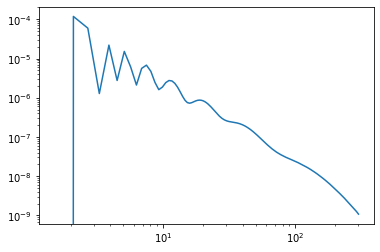

In [68]:
plt.plot(rad_hernq, field_hernq) 
plt.xscale('log')
plt.yscale('log')